In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import Tree
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
def mse(pred, actual):
    return np.mean(np.square(pred - actual))

def R_squared(pred, actual):
        r_sq = 1 - mse(pred, actual)/ mse(actual.mean(), actual)
        return r_sq

# Data

In [3]:
data = pd.read_csv("data/winequality-red.csv",delimiter = ";")

In [4]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
# Train test split
index = [i for i in range(len(data))]
np.random.shuffle(index)
train_index = index[:int(len(index)*0.6)]
test_index = index[int(len(index)*0.6):]

train_data = data.loc[train_index]
test_data = data.loc[test_index]

X_train, y_train = train_data.drop('quality', axis = 1).values, train_data.quality.values
X_test, y_test = test_data.drop('quality', axis = 1).values, test_data.quality.values
train_data.shape, test_data.shape

((959, 12), (640, 12))

# Comparing decision trees to random forest

In [6]:
results = []

# Fitting decision tree and random forest of different tree depth to visualize the 
# test set performance of the two model types
for depth in [1, 2, 3,10,20]:
    basic_tree = Tree.DecisionTreeRegression(max_depth = depth)
    rf = Tree.RandomForest(10, depth)
    basic_tree.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    pred_basic = basic_tree.predict(X_test)
    pred_rf = rf.predict(X_test)
    results.append([depth, R_squared(pred_basic, y_test), R_squared(pred_rf, y_test)])
    print(".", sep = "", end = "")

.....

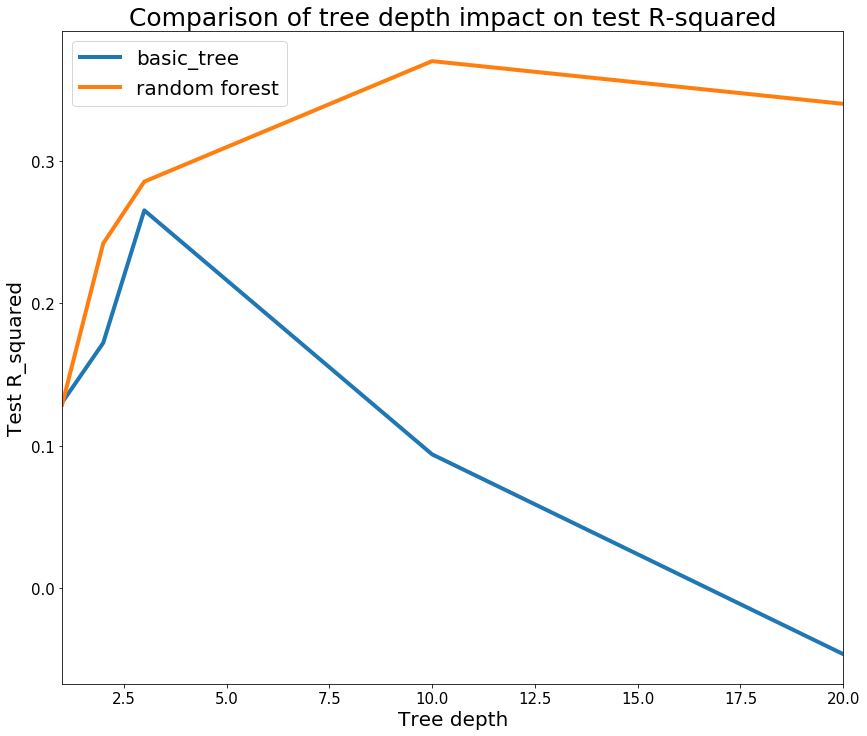

In [7]:
results = pd.DataFrame(results, columns = ["depth", "basic_tree", "random forest"])
fig, ax = plt.subplots(figsize = (14, 12))
results.set_index('depth').plot(ax = ax, linewidth = 4)
plt.title("Comparison of tree depth impact on test R-squared", fontsize = 25)
plt.ylabel("Test R_squared", fontsize = 20)
plt.xlabel("Tree depth", fontsize = 20)
plt.legend(prop={'size': 20})
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()
fig.savefig("results/rf_basic_variance_comparison.png")


# Grid search for random forest

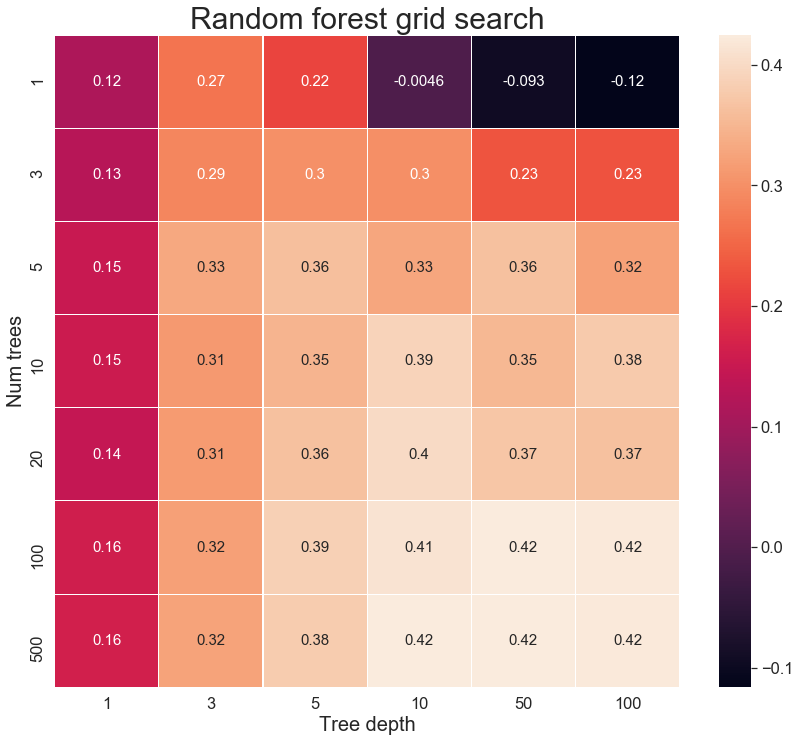

In [163]:
trees =  [1, 3, 5, 10, 20, 100, 500]
depths = [1, 3, 5, 10, 50, 100]

scores = []
for t in trees:
    for d in depths:
#         model = Tree.RandomForest(t, d)
        model = RandomForestRegressor(n_estimators = t, max_depth=d)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        scores.append([t, d, R_squared(pred, y_test)])

sns.set(font_scale=1.5)
matrix = np.array(scores)[:,2].reshape(len(trees), len(depths))
matrix = pd.DataFrame(matrix, columns = depths, index = trees)
fig, ax = plt.subplots(figsize = (14,12))
sns.heatmap(matrix, linewidth=0.1, annot = True, annot_kws={"size": 15})
plt.title("Random forest grid search", fontsize = 30)
plt.ylabel("Num trees", fontsize = 20)
plt.xlabel("Tree depth", fontsize = 20)
plt.show()
fig.savefig("results/RF_grid_search_plot.png")

# Grid search for GBM

In [164]:
estimators = [1, 3, 10, 20, 50, 100, 500]
depths = [1, 3, 5, 10, 50]

scores = []
for t in estimators:
    print(t)
    for d in depths:
#         model = Tree.GBM(n_estimators = t, tree_depth = d)
        model = GradientBoostingRegressor(n_estimators = t, max_depth = d)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        scores.append([t, d, R_squared(pred, y_test)])
    

1
3
10
20
50
100
500


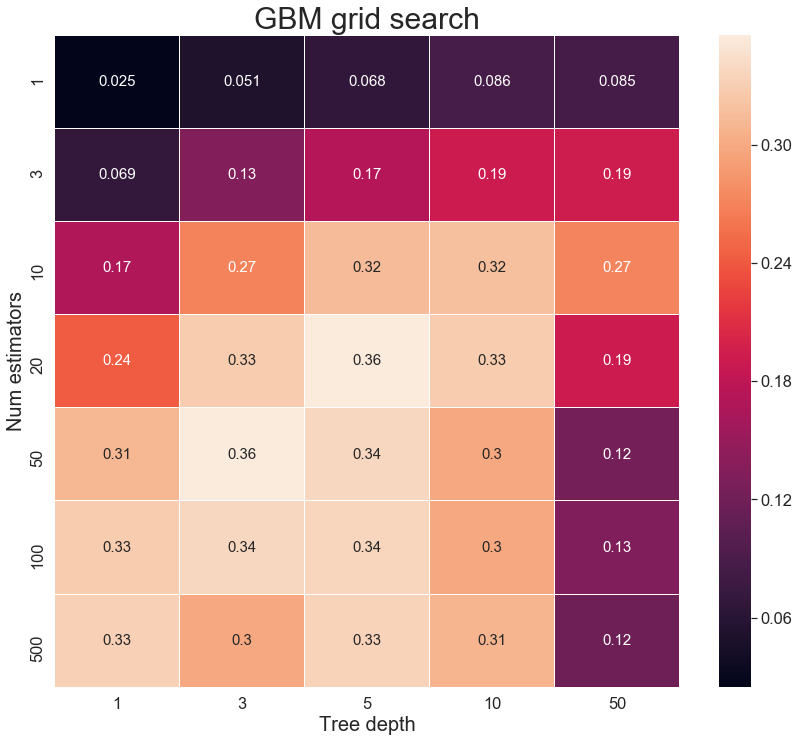

In [165]:
sns.set(font_scale=1.5)
matrix = np.array(scores)[:,2].reshape(len(estimators), len(depths))
matrix = pd.DataFrame(matrix, columns = depths, index = estimators)
fig, ax = plt.subplots(figsize = (14,12))

sns.heatmap(matrix, linewidth=0.1, annot = True, annot_kws={"size": 15})
plt.title("GBM grid search", fontsize = 30)
plt.ylabel("Num estimators", fontsize = 20)
plt.xlabel("Tree depth", fontsize = 20)
plt.show()
fig.savefig("results/GBM_grid_search_plot.png")

# XGBOOST

In [11]:
import xgboost
estimators = [50, 100, 500]
depths = [3, 5, 7]

scores = []
for t in estimators:
    print(t)
    for d in depths:
        model = xgboost.XGBRegressor(n_estimators = t, max_depth = d, 
                                     objective = 'reg:squarederror')
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        scores.append([t, d, R_squared(pred, y_test)])

50
100
500


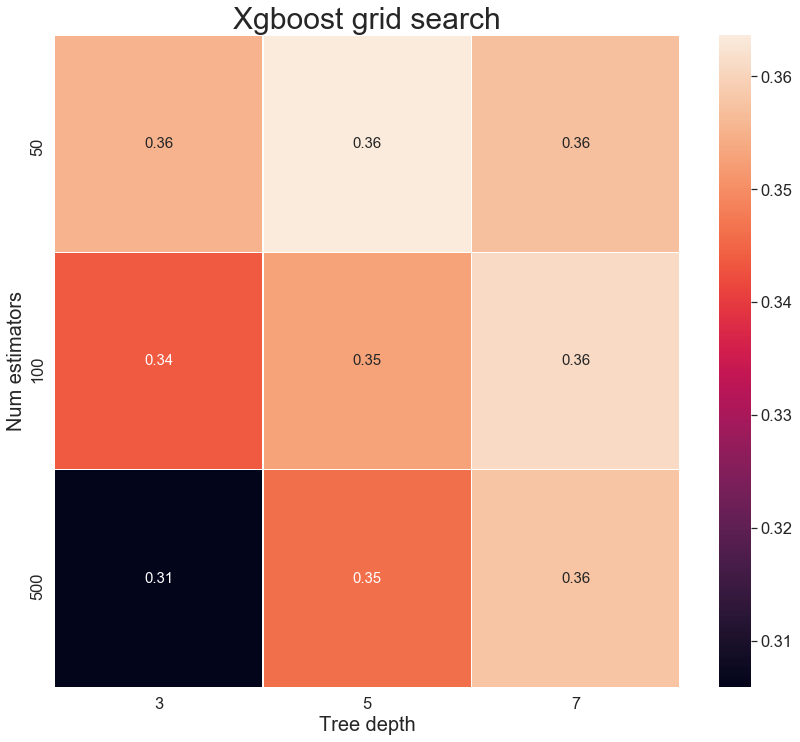

In [12]:
sns.set(font_scale=1.5)
matrix = np.array(scores)[:,2].reshape(len(estimators), len(depths))
matrix = pd.DataFrame(matrix, columns = depths, index = estimators)
fig, ax = plt.subplots(figsize = (14,12))

sns.heatmap(matrix, linewidth=0.1, annot = True, annot_kws={"size": 15})
plt.title("Xgboost grid search", fontsize = 30)
plt.ylabel("Num estimators", fontsize = 20)
plt.xlabel("Tree depth", fontsize = 20)
plt.show()
fig.savefig("results/XGBOOST_grid_search_plot.png")

# Comparing model performance

In [13]:
# Using library implementations for this part because of speed improvements compared to our own
# implementations


def grid_search(estimators, depths, Model):
    scores = []
    best_model = None
    best_score = -np.inf
    for t in estimators:
        for d in depths:
            model = Model(max_depth = d, n_estimators = t)
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            score = R_squared(pred, y_test)
            if score > best_score:
                best_score = score
                best_model = model
            scores.append([t, d, score])
    scores = pd.DataFrame(scores, columns = ['estimators', 'depth', 'score'])
    scores = scores[scores.score == scores.score.max()]
    return scores, best_model 

def add_name(df, name):
    df.index = [name]
    return df

def results(dfs, names = ['RF', 'GBM', 'XGBOOST']):
    for df, name in zip(dfs, names):
        df.index = [name]
    df = pd.concat(dfs, axis = 0)
    return df

# Getting results for random forest, gbm and xgboost
rf_results, rf_model = grid_search([10, 50, 100, 400], [5, 10, 20, 50, 100], RandomForestRegressor)
gbm_results, gbm_model = grid_search([10, 50, 100, 400], [3, 5, 10], GradientBoostingRegressor)
xgboost_results, xgboost_model = grid_search([10, 50, 100, 400], [3, 5, 10], xgboost.XGBRegressor)
results([rf_results, gbm_results, xgboost_results]).to_csv("results/model_results.csv")

[13:22:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:23:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:23:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:23:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:23:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:23:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:23:00] WARNI

In [166]:
pd.read_csv("results/model_results.csv")

,Unnamed: 0,estimators,depth,score
0,RF,400,50,0.423968
1,GBM,50,5,0.355838
2,XGBOOST,50,10,0.382007


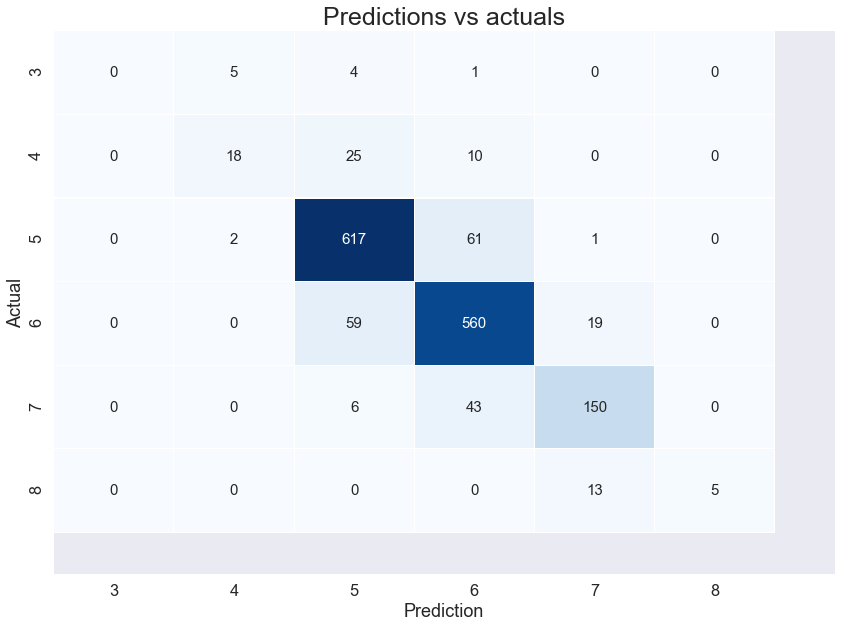

In [218]:
# Plot predictions vs actuals
from sklearn.metrics import confusion_matrix
X = data.drop('quality', axis = 1).values
y = data.quality.values
pred = rf_model.predict(X).round()
cm = confusion_matrix(y, (pred))
# cm = cm[:,1:]

fig, ax = plt.subplots(figsize = (14,10))
sns.heatmap(cm, linewidth=0.1, annot = True, annot_kws={"size": 15}, fmt='g', cbar = False, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Prediction")
plt.xticks([.5,1.5,2.5,3.5,4.5,5.5,6.5], [3,4,5,6,7,8])
plt.yticks([.5,1.5,2.5,3.5,4.5,5.5,6.5], [3,4,5,6,7,8])
plt.title("Predictions vs actuals", fontsize = 25)
fig.savefig("results/pred_vs_act.png")

# Interpretation

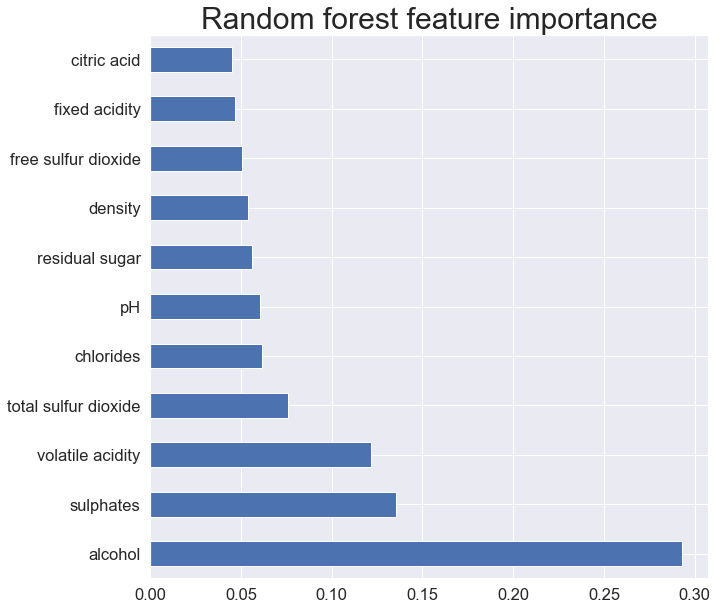

In [219]:
# Plotting feature importance from the different models. 
fig, ax = plt.subplots(figsize = (10, 10))
(pd.Series(rf_model.feature_importances_, index=data.columns[:11])
   .nlargest(20)
   .plot(kind = 'barh',ax = ax))
plt.title("Random forest feature importance", fontsize = 30)
fig.savefig("results/feature_importance.png")

Text(0.5, 1.0, 'GBM feature importance')

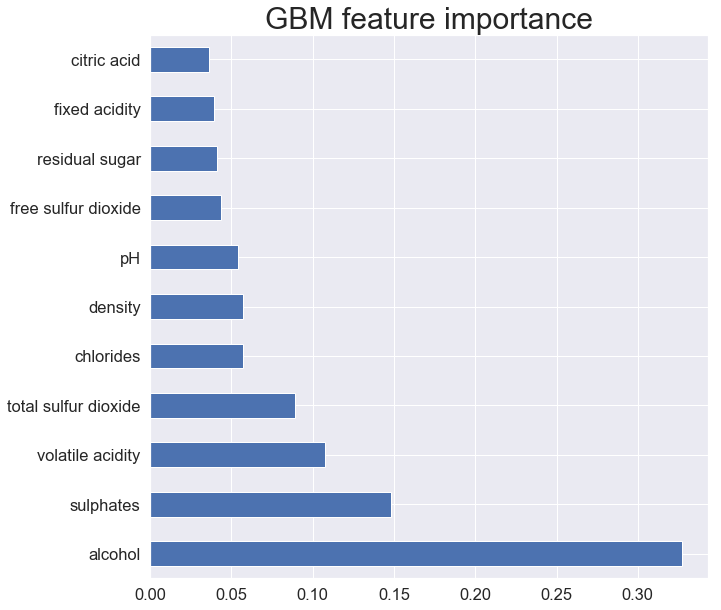

In [141]:
fig, ax = plt.subplots(figsize = (10, 10))
(pd.Series(gbm_model.feature_importances_, index=data.columns[:11])
   .nlargest(20)
   .plot(kind='barh', ax = ax))
plt.title("GBM feature importance", fontsize = 30)

Text(0.5, 1.0, 'Xgboost feature importance')

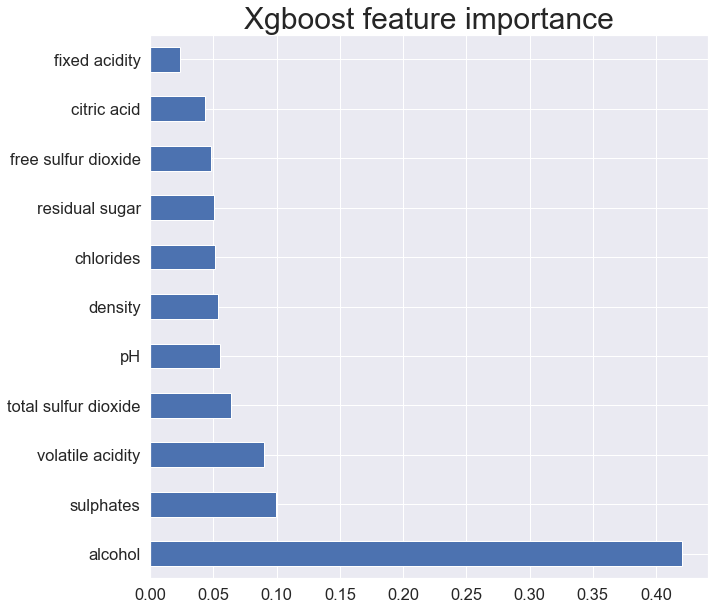

In [142]:
fig, ax = plt.subplots(figsize = (10, 10))
(pd.Series(xgboost_model.feature_importances_, index=data.columns[:11])
   .nlargest(20)
   .plot(kind='barh', ax = ax))
plt.title("Xgboost feature importance", fontsize = 30)

In [223]:
def partial_dependence(X, feature_index, model):
    """
    Examining the effect of variables, by using the trained model
    to make predictions for different levels of a variable while keeping
    the other variables unchanged.
    
    """
    feature_values = X[:,feature_index]
    values = np.percentile(feature_values, [i for i in range(1, 100, 1)])
    X_copy = X.copy()
    means = []
    stds = []
    for value in values:
        X_copy[:,feature_index] = value
        pred = model.predict(X_copy)
        mean = np.mean(pred)
        std = np.std(pred)
        
        means.append(mean)
        stds.append(std)
        
    return np.array(means), np.array(values), np.array(stds)



def plot_partial_dependence(X, feature_index, model, feature_name):
    means, values, stds = partial_dependence(X, feature_index, model)
    
    fig, ax = plt.subplots(figsize = (12, 10))
    plt.plot(values, means)
    plt.fill_between(values, means-stds, means+stds, alpha = 0.2)
    plt.title(f"Partial dependence for {feature_name}", fontsize = 30)
    plt.xlabel(f"{feature_name} level")
    plt.ylabel("Quality")
    fig.savefig(f"results/partial_dependence_{feature_name}.png")
    plt.show()

In [224]:
# Top 3 features according to random forest model
top3 = np.argsort(-rf_model.feature_importances_)[:3]
names = data.drop('quality', axis = 1).columns

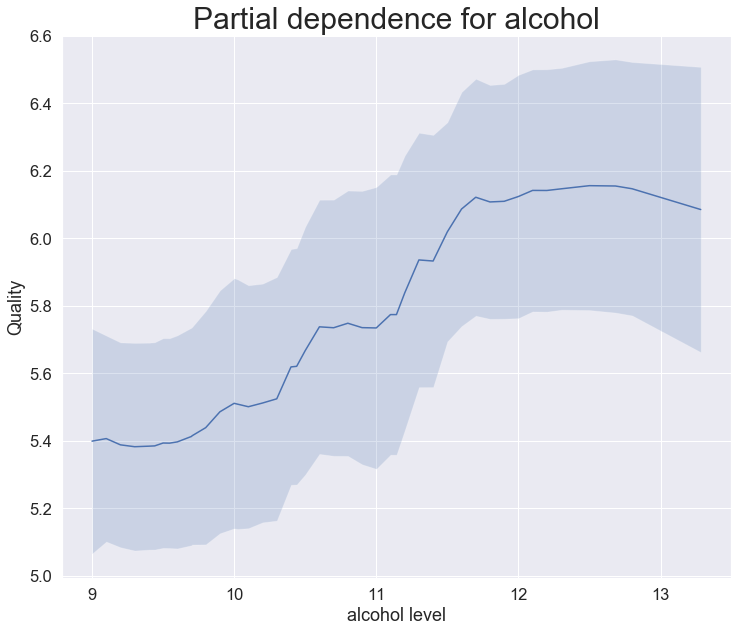

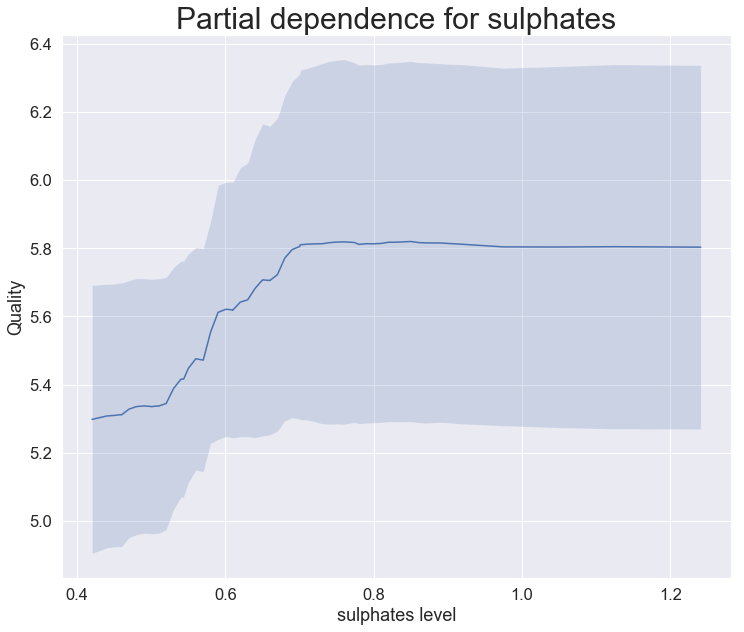

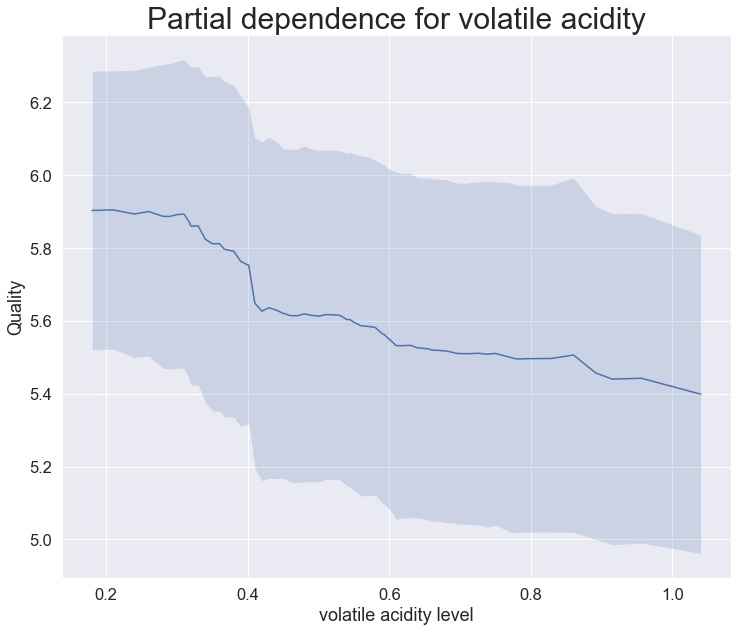

In [225]:
for idx in top3:
    plot_partial_dependence(X_test, idx, rf_model, names[idx])

# Tree interpolation 

In [305]:
train_size = 1000
test_size = 1000

x = np.arange(0,train_size,1).reshape(-1,1)
y = 5 + x * 3 + (np.random.randn(train_size)*500).reshape(-1,1)
x_test = np.arange(train_size,train_size+test_size,1).reshape(-1,1)
y_test = 5 + x_test * 3 + (np.random.randn(test_size)*500).reshape(-1,1)

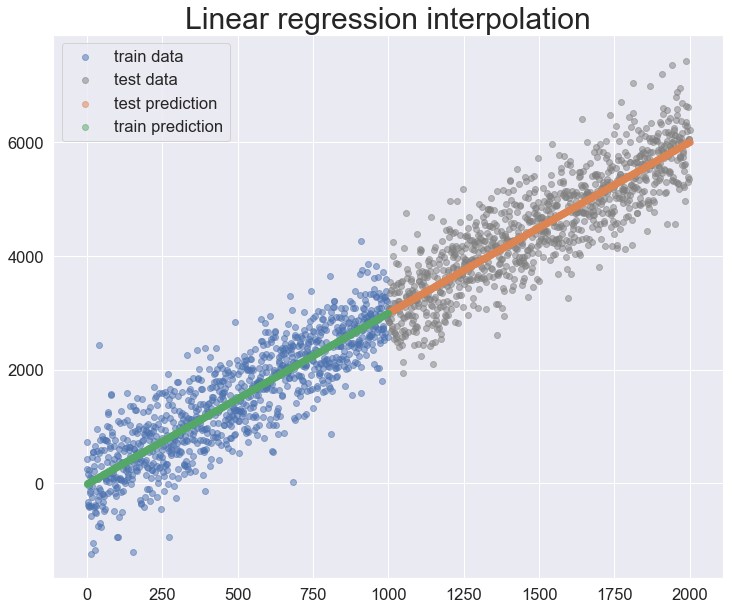

In [315]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x, y)

pred = lin_reg.predict(x_test)
train_pred = lin_reg.predict(x)

fig, ax = plt.subplots(figsize = (12,10))
plt.scatter(x, y, label = 'train data', alpha = 0.5)
plt.scatter(x_test, y_test, label = "test data", alpha = 0.5, color = "grey")
plt.scatter(x_test, pred, label = 'test prediction', alpha = 0.5)
plt.scatter(x, train_pred, label = 'train prediction', alpha = 0.5)


plt.legend()
plt.title("Linear regression interpolation", fontsize = 30)
fig.savefig("results/linear_regression_interpolation.png")

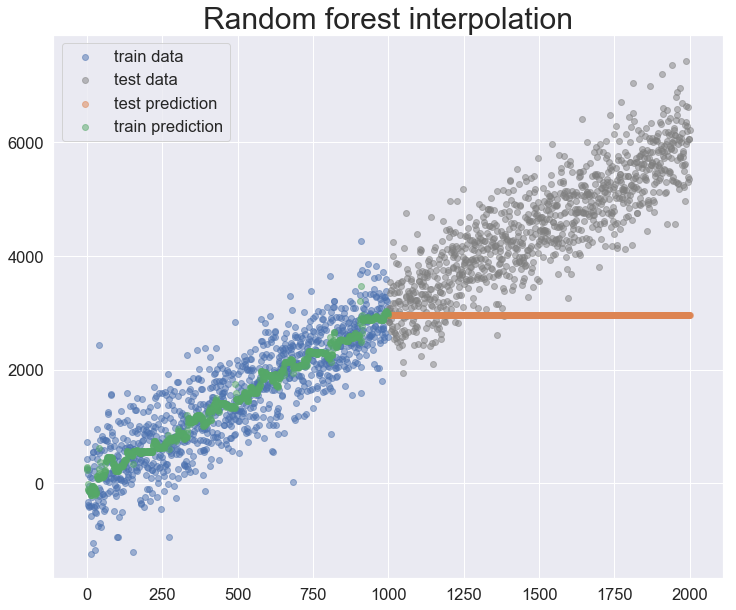

In [316]:
from sklearn.linear_model import LinearRegression
lin_reg = RandomForestRegressor(n_estimators=300, max_depth = 5)
lin_reg.fit(x, y)

pred = lin_reg.predict(x_test)
train_pred = lin_reg.predict(x)

fig, ax = plt.subplots(figsize = (12,10))
plt.scatter(x, y, label = 'train data', alpha = 0.5)
plt.scatter(x_test, y_test, label = "test data", alpha = 0.5, color = "grey")
plt.scatter(x_test, pred, label = 'test prediction', alpha = 0.5)
plt.scatter(x, train_pred, label = 'train prediction', alpha = 0.5)


plt.legend()
plt.title("Random forest interpolation", fontsize = 30)
fig.savefig("results/random_forest_interpolation.png")

# Comparing our implementation to sklearn regression tree

In [17]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth = 2)
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [57]:
tree2 = Tree.DecisionTreeRegression(max_depth = 2)
tree2.fit(X_train, y_train)
def print_node(node):
    return f"({round(node.left.prediction, 3)}  {round(node.right.prediction, 3)})"

def print_nums(a, b):
    return f"({round(float(a), 3)}  {round(float(b), 3)})"


In [78]:
# We can see that our implementation gives the same result as that of sklearn.
print("Our tree:", 
      '\n', 
      20*' ', round(tree2.tree_.prediction, 3), '\n', 
      15*' ', print_node(tree2.tree_), "\n",
      5*' ', print_node(tree2.tree_.left), 4*' ' ,print_node(tree2.tree_.right))
print(" ")
print("sklearn tree:", 
      '\n', 
      20*' ', round(float(tree.tree_.value[0]), 3), '\n', 
      15*' ', print_nums(tree.tree_.value[1],tree.tree_.value[4]), "\n",
      5*' ', print_nums(tree.tree_.value[2],tree.tree_.value[3]), 4*' ' ,print_nums(tree.tree_.value[5],tree.tree_.value[6]) )

Our tree: 
                      5.661 
                 (5.34  6.061) 
       (5.728  5.247)      (5.59  6.239)
 
sklearn tree: 
                      5.661 
                 (5.34  6.061) 
       (5.728  5.247)      (5.59  6.239)


In [76]:
# Comparing performance of random forest and gbm
import warnings
warnings.filterwarnings("ignore")
print("Comparing R-squared of GBM implementations:")
for trees in [5,10,20]:
    our_gbm = Tree.GBM(n_estimators = trees, tree_depth = 3)
    sklearn_gbm = GradientBoostingRegressor(n_estimators = trees)
    our_gbm.fit(X_train, y_train)
    sklearn_gbm.fit(X_train, y_train)
    our_pred = our_gbm.predict(X_test)
    sklearn_pred = sklearn_gbm.predict(X_test)
    print(f"\nNumber of estimators : {trees}")
    print(f"our : {round(R_squared(our_pred, y_test), 3)}\nsklearn : {round(R_squared(sklearn_pred, y_test), 3)}")

Comparing R-squared of GBM implementations:

Number of estimators : 5
our : 0.195
sklearn : 0.193

Number of estimators : 10
our : 0.277
sklearn : 0.27

Number of estimators : 20
our : 0.335
sklearn : 0.329


In [77]:
print("Comparing R-squared of Random Forest implementations:")
for depth in [5,10,20]:
    our_rf = Tree.RandomForest(n_trees = 20, tree_depth = depth)
    sklearn_rf = RandomForestRegressor(n_estimators = 20, max_depth = depth)
    our_rf.fit(X_train, y_train)
    sklearn_rf.fit(X_train, y_train)
    our_pred = our_rf.predict(X_test)
    sklearn_pred = sklearn_rf.predict(X_test)
    print(f"\nDepth of estimators : {depth}")
    print(f"our : {round(R_squared(our_pred, y_test), 3)}\nsklearn : {round(R_squared(sklearn_pred, y_test), 3)}")

Comparing R-squared of Random Forest implementations:

Depth of estimators : 5
our : 0.37
sklearn : 0.386

Depth of estimators : 10
our : 0.398
sklearn : 0.377

Depth of estimators : 20
our : 0.372
sklearn : 0.371


In [ ]:
# Comparing the time each implementation uses to fit the data. We see a significant 
# difference in speed favoring sklearn's implementation.

In [91]:
%%timeit
clf = DecisionTreeRegressor(max_depth = 10).fit(X_train, y_train)

10.9 ms ± 776 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [92]:
%%timeit
clf = Tree.DecisionTreeRegression(max_depth = 10)
clf.fit(X_train, y_train)

2.13 s ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
